# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path
import json

Load libraries for analysis and visualization:

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Import the LensKit metrics for analysis:

In [3]:
from lenskit.data import Dataset, ItemListCollection
from lenskit.metrics import RunAnalysis, RMSE, NDCG, RecipRank, RBP

In [4]:
from lkdemo.datasets import split_fraction

## Load Data

The recommendations are in `runs`, and we will need to reassemble the test data from `test`.

In [5]:
dataset = "ml-100k"

In [6]:
# Parameters
dataset = "ml-10m"


In [7]:
output_root = Path("runs")

In [8]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [9]:
recs = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = ItemListCollection.load_parquet(file)
        recs.add_from(rec, model=fld.name.split("-")[-1])

In [10]:
rec_algos = sorted(set(a for (a, _u) in recs.keys()))
rec_algos

['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop', 'UUE']

In [11]:
preds = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = ItemListCollection.load_parquet(file)
        preds.add_from(pred, model=fld.name.split("-")[-1])

We need to load the test data so that we have the ground truths for computing accuracy.

In [12]:
data = Dataset.load(f"data/{dataset}")
split = split_fraction(data, 0.2)
test = split.test

And identify users in the training set, so we only report metrics over them.

In [13]:
train_users = split.train.user_stats()
train_users = train_users[train_users['rating_count'] > 0]

## Top-N Metrics

`RunListAnalysis` computes metrics for recommendation results and takes care of
matching recommendations and ground truth.

In [14]:
ra = RunAnalysis()

ra.add_metric(NDCG())
ra.add_metric(RecipRank())
ra.add_metric(RBP())

rec_results = ra.compute(recs, test)
rec_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


mean    median       std
model                                        
ALS   NDCG       0.121753  0.107308  0.095810
      RBP        0.223468  0.158808  0.217678
      RecipRank  0.527108  0.500000  0.438996
Bias  NDCG       0.122468  0.108842  0.095923
      RBP        0.226528  0.162843  0.217737
      RecipRank  0.542384  0.500000  0.439935
IALS  NDCG       0.042983  0.022689  0.067086
      RBP        0.035575  0.001018  0.108561
      RecipRank  0.081426  0.030303  0.187797
IIE   NDCG       0.008394  0.000000  0.026761
      RBP        0.007472  0.000000  0.041989
      RecipRank  0.017134  0.000000  0.082209
III   NDCG       0.034176  0.000000  0.092084
      RBP        0.047779  0.000000  0.150655
      RecipRank  0.082717  0.000000  0.242442
Pop   NDCG       0.207656  0.192260  0.156670
      RBP        0.383919  0.325337  0.330449
      RecipRank  0.577445  0.500000  0.426818
UUE   NDCG       0.007588  0.000000  0.022640
      RBP        0.004828  0.000000  0.027005
      RecipRank  0.010990  0.000000  0.042649

We can reshape the list metrics and plot them, after filtering to only users with at least 1 training rating:

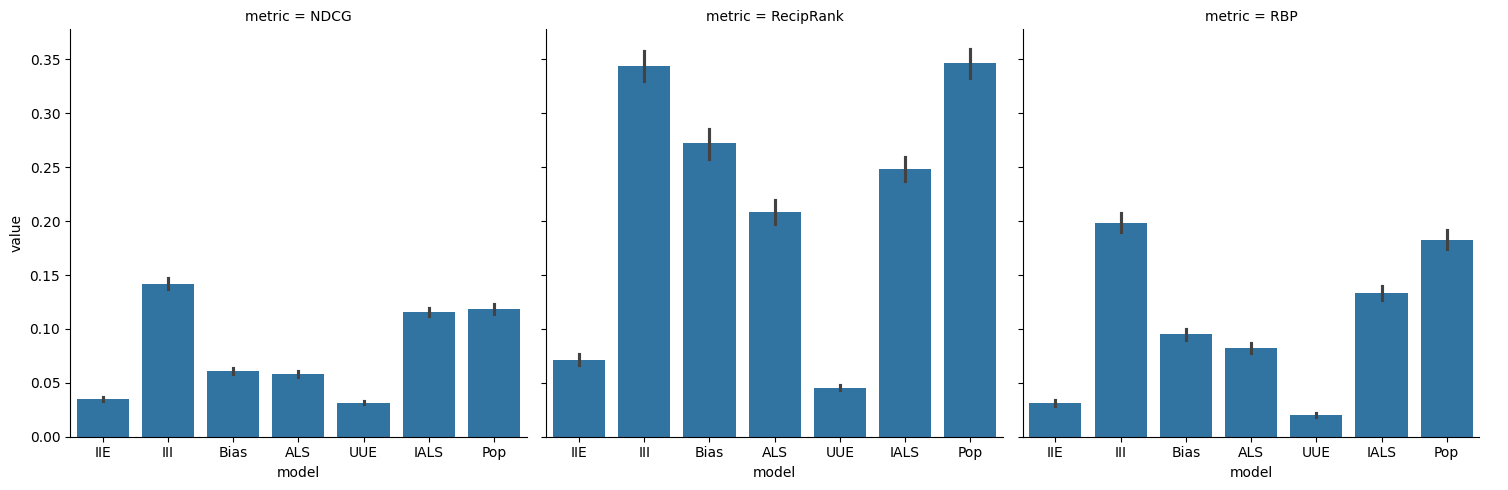

In [15]:
metrics = rec_results.list_metrics()
metrics = metrics.melt(var_name='metric', ignore_index=False).reset_index()
metrics = metrics[metrics['user_id'].isin(train_users.index)]
sns.catplot(metrics, x='model', y='value', col='metric', kind='bar')
plt.show()

Let's look at the influence of training ratings on performance, clamping 15+ into a single category:

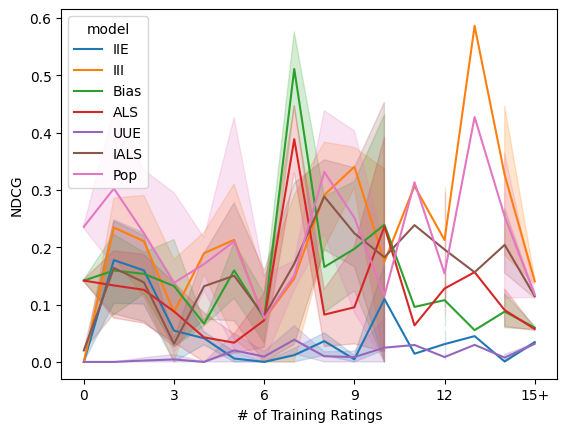

In [16]:
tcounts = split.train.user_stats()['rating_count'].copy()
tcounts[tcounts > 15] = 15
metrics = rec_results.list_metrics().reset_index().join(tcounts, on='user_id')
sns.lineplot(metrics, x='rating_count', y='NDCG', hue='model', errorbar='ci')
plt.xlabel('# of Training Ratings')
rc_ticks = np.arange(0, 16, 3)
plt.xticks(rc_ticks, rc_ticks[:-1].tolist() + ['15+'])
plt.show()

## Prediction RMSE

We will also look at the prediction RMSE.

In [17]:
pa = RunAnalysis()

pa.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))

pred_results = pa.compute(preds, test)
pred_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,,mean,median,std
model,,,,
ALS,RMSE,0.903379,0.850329,0.303010
Bias,RMSE,0.908350,0.854235,0.301733
IIE,RMSE,0.903569,0.850261,0.304478
UUE,RMSE,0.908947,0.854993,0.303898


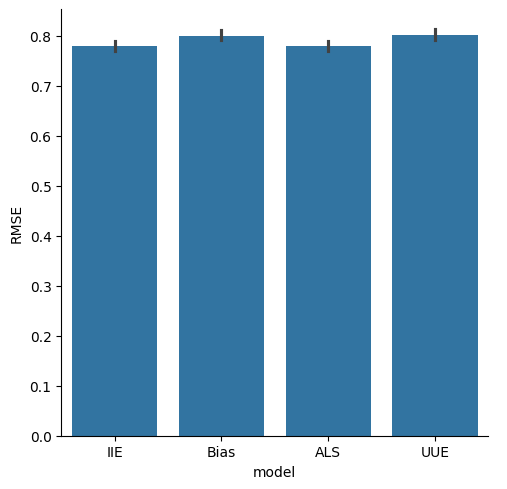

In [18]:
pred_metrics = pred_results.list_metrics().reset_index()
pred_metrics = pred_metrics[pred_metrics['user_id'].isin(train_users.index)]
sns.catplot(pred_metrics, x='model', y='RMSE', kind='bar')
plt.show()

## Save Metrics

We'll now save the metrics to a file.

In [19]:
rlsum = rec_results.list_summary('model')['mean'].unstack()
rlsum

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,NDCG,RBP,RecipRank
model,,,
ALS,0.121753,0.223468,0.527108
Bias,0.122468,0.226528,0.542384
IALS,0.042983,0.035575,0.081426
IIE,0.008394,0.007472,0.017134
III,0.034176,0.047779,0.082717
Pop,0.207656,0.383919,0.577445
UUE,0.007588,0.004828,0.010990


In [20]:
rlsum.to_json(f'eval-metrics.{dataset}.json', orient='index')